# Walmart sales project

In this project we study the sales of Walmart stores. Our goal is to predict the weekly sales of various stores as a function of factors such as the period of the year or various economical indicators. The dataset contains few observations, many of which have missing values. This is in contrast with the other projects of this category. The analysis carried here thus illustrates the handling of missing data, a common task in data science.


Contents
--------
1. [Data loading and preprocessing](#loading)
2. [Exploratory data analysis](#eda)
3. [Missing data imputation](#imputation)
4. [Unregularized linear model](#linreg)
5. [Lasso-regularized linear model](#lasso_linreg)
6. [Conclusion](#conclusion)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (mean_squared_error,
                             r2_score,
                             mean_absolute_error,
                             mean_absolute_percentage_error)
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (OneHotEncoder,
                                   StandardScaler,
                                   FunctionTransformer)
from sklearn.linear_model import LinearRegression, Lasso

## <a id="loading"></a> Data loading and preprocessing

In [4]:
# Load data
raw_df = pd.read_csv('./Walmart_Store_sales.csv')
raw_df = raw_df.assign(Store=raw_df['Store'].astype(int))
raw_df = raw_df.assign(Date=pd.to_datetime(raw_df['Date'], format='%d-%m-%Y'))
# Remove records with NaNs in target 'Weekly_Sales'
df = raw_df.dropna(subset=['Weekly_Sales'])

df_desc = df.describe()
df_desc

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,136.000000,118,1.360000e+02,125.000000,121.000000,124.000000,125.000000,122.000000
mean,10.014706,2011-04-23 04:28:28.474576384,1.249536e+06,0.072000,60.853967,3.316992,178.091144,7.665582
min,1.000000,2010-02-05 00:00:00,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,2010-07-30 00:00:00,6.050757e+05,0.000000,45.220000,2.838500,131.637000,6.690000
50%,10.000000,2011-04-29 00:00:00,1.261424e+06,0.000000,62.250000,3.451000,196.919506,7.477000
75%,15.250000,2011-12-31 18:00:00,1.806386e+06,0.000000,75.950000,3.724000,214.878556,8.150000
max,20.000000,2012-10-19 00:00:00,2.771397e+06,1.000000,91.650000,4.193000,226.968844,14.313000
std,6.124614,NaN,6.474630e+05,0.259528,18.514432,0.479540,40.243105,1.619428


We remove outlier observations in the numeric features `Temperature`, `Fuel_Price`, `CPI`, `Unemployment`. Are considered as outliers those features values which lie more than 3 standard deviations from the mean.

In [5]:
num_features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
means = df_desc.loc['mean', num_features]
stds = df_desc.loc['std', num_features]
pd.concat([means - 3*stds, df_desc.loc[['min', 'max'], num_features].T, means + 3*stds], axis=1)

,0,min,max,1
Temperature,5.310671,18.790000,91.650000,116.397263
Fuel_Price,1.878371,2.514000,4.193000,4.755613
CPI,57.36183,126.111903,226.968844,298.820458
Unemployment,2.807297,5.143000,14.313000,12.523867


The lower bound for outlier exclusion is indicated as the column `0`, while the upper bound is the column `1`. The numerical features are all within the bounds. However, doing a filtering such as
```python
(df[feature] >= mean-3*std) & (df[feature] <= mean+3*std)
```
would return `True` for missing values (NaNs). It would effectively remove those observations which have at least one missing numerical feature. Doing so reduces the dataset to only 90 observations, and we assume that it is undesired. We will rather rely on an imputing strategy for the missing values.

Before that, we process the date to convert it into a numerical timestamp. The weekly sales were aggregated on a weekly basis, every friday. We therefore extract only the year, month and week number from the date.

In [6]:
df = df.assign(Date=pd.to_datetime(df['Date'], format='%d-%m-%Y'))
df['Date'].dt.day_name()

0      Friday
1      Friday
3         NaN
4      Friday
5      Friday
        ...  
145    Friday
146       NaN
147    Friday
148    Friday
149    Friday
Name: Date, Length: 136, dtype: object

In [7]:
df.loc[:, 'Year'] = df['Date'].dt.year
df.loc[:, 'Month'] = df['Date'].dt.month
df.loc[:, 'Week'] = df['Date'].dt.isocalendar().week

## <a id="eda"></a> Exploratory data analysis

#### ?

We begin by getting insights about the store locations.

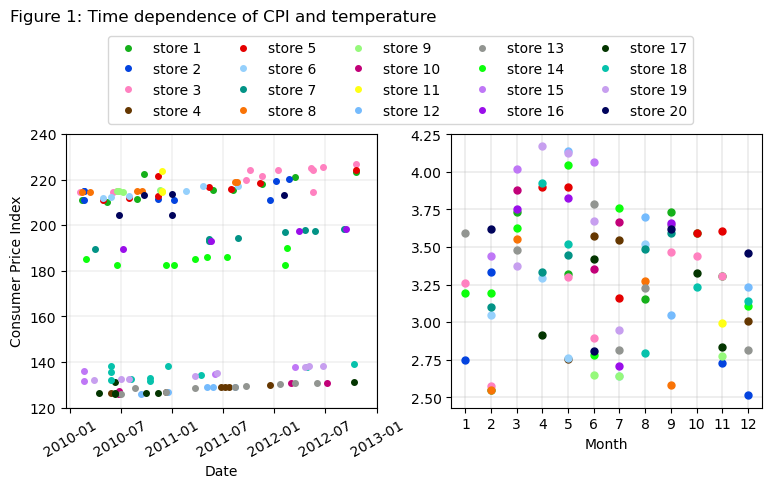

In [36]:
COLORS = [
    '#7e1e9c', '#15b01a', '#0343df', '#ff81c0', '#653700', '#e50000',
    '#95d0fc', '#029386', '#f97306', '#96f97b', '#c20078', '#ffff14',
    '#75bbfd', '#929591', '#0cff0c', '#bf77f6', '#9a0eea', '#033500',
    '#06c2ac', '#c79fef', '#00035b', '#d1b26f', '#00ffff', '#06470c',
    ]


fig1, axs1 = plt.subplots(
    nrows=1, ncols=2, sharey=False, figsize=(8, 4.8), dpi=100,
    gridspec_kw={'left': 0.09, 'right': 0.96, 'top': 0.72, 'bottom': 0.15, 'wspace': 0.24})
fig1.suptitle("Figure 1: Time dependence of CPI and temperature",
              x=0.02, ha='left')

handles, labels = [], []
for istore, store_df in df.groupby('Store'):
    # CPI vs date
    line, = axs1[0].plot(store_df['Date'], store_df['CPI'], color=COLORS[istore],
                         marker='o', markersize=4, linestyle='')

    # temperature vs month
    gdf = store_df.groupby('Month').mean()
    axs1[1].plot(gdf.index, gdf['Fuel_Price'], color=COLORS[istore],
                 marker='o', markersize=5, linestyle='')

    # legend handles and labels
    handles.append(line)
    labels.append(f'store {istore}')

dates = pd.date_range(start='1/1/2010', end='1/1/2013', freq='6MS')
axs1[0].set_xticks(dates, dates.strftime('%Y-%m'), rotation=30)
axs1[0].set_xlabel('Date')
axs1[0].set_ylim(120, 240)
axs1[0].set_ylabel('Consumer Price Index')
axs1[0].grid(visible=True, linewidth=0.2)

axs1[1].set_xticks(np.arange(1, 13, 1))
axs1[1].set_xlabel('Month')
# axs1[1].set_ylim(0, 100)
# axs1[1].set_yticks(np.arange(10, 100, 20), minor=True)
# axs1[1].set_ylabel('Temperature (°F)', labelpad=2)
axs1[1].grid(visible=True, linewidth=0.3)
axs1[1].grid(visible=True, which='minor', linewidth=0.2)

fig1.legend(handles=handles, labels=labels,
            ncols=5, loc=(0.14, 0.745), alignment='center')

plt.show()

We show on the left panel of figure 1 the time dependence of the consumer price index for each store. The observed slow increase over time is due to inflation. We can clearly split the stores into 3 groups based on the range of CPI values : those probably correspond to stores located in different regions of the world.

The right panels shows the monthly average of the temperature (right panel). For each store, the temperature follows the north hemisphere seasonal variations.

#### Box plots

We proceed with box plots

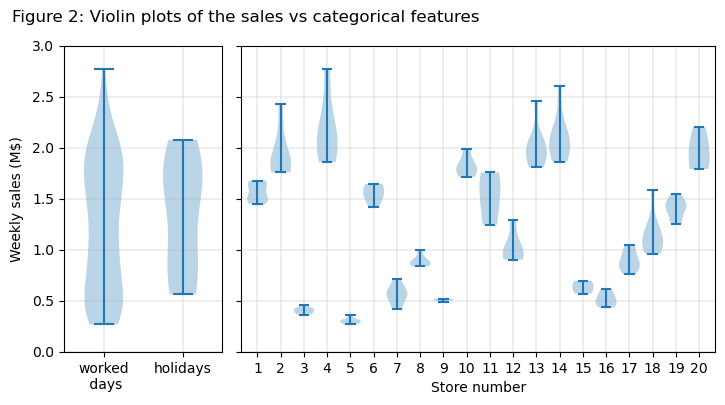

In [35]:
fig2, axs2 = plt.subplots(
    nrows=1, ncols=2, sharey=True, figsize=(7.4, 4.), dpi=100,
    gridspec_kw={'left': 0.09, 'right': 0.97, 'top': 0.89, 'bottom': 0.125,
                 'wspace': 0.06, 'width_ratios': [0.5, 1.5]})
fig2.suptitle("Figure 2: Violin plots of the sales vs categorical features",
              x=0.02, ha='left')


holiday_gdf = {i: df_['Weekly_Sales'] for i, df_ in df.groupby('Holiday_Flag')}
axs2[0].violinplot(list(holiday_gdf.values()), positions=list(holiday_gdf.keys()),
                   widths=0.5)

axs2[0].set_xlim(-0.5, 1.5)
axs2[0].set_xticks([0, 1], ['worked\n days', 'holidays'])
axs2[0].set_ylim(0, 3e6)
axs2[0].set_yticks(np.linspace(0, 3e6, 7), np.linspace(0, 3, 7))
axs2[0].set_ylabel('Weekly sales (M$)', labelpad=6)
axs2[0].grid(visible=True, linewidth=0.3)


store_gdf = {i: df_['Weekly_Sales'] for i, df_ in df.groupby('Store')}
axs2[1].violinplot(list(store_gdf.values()), positions=list(store_gdf.keys()),
                   widths=0.9)

axs2[1].set_xlim(0.3, 20.7)
axs2[1].set_xticks(np.arange(1, 21))
axs2[1].set_xlabel('Store number')
axs2[1].grid(visible=True, linewidth=0.3)

plt.show()

For some stores, there are some events in which the weekly sales are about 10-20% higher
than the rest of the time.
This can be due to christmas / black friday

#### Scatter plots

We conclude with scatter plots

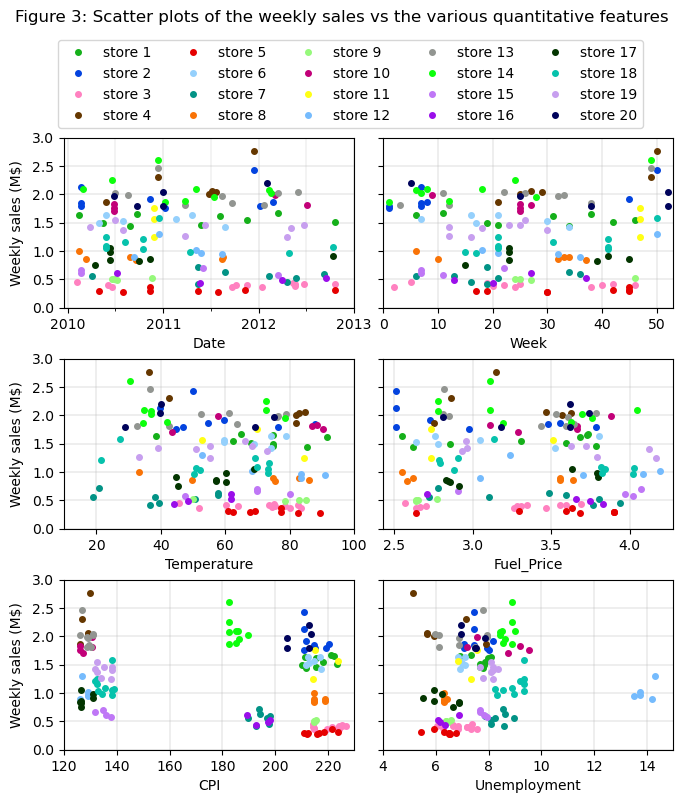

In [34]:
features = ['Date', 'Week', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']


fig3, axs3 = plt.subplots(
    nrows=3, ncols=2, sharey=True, figsize=(7, 8), dpi=100,
    gridspec_kw={'left': 0.09, 'right': 0.96, 'top': 0.83, 'bottom': 0.065,
                 'wspace': 0.10, 'hspace': 0.3})
fig3.suptitle("Figure 3: Scatter plots of the weekly sales vs the various quantitative features",
              x=0.02, y=0.99, ha='left')


handles, labels = [], []
for istore, store_df in df.groupby('Store'):
    for feature, ax in zip(features, axs3.ravel()):
        line, = ax.plot(store_df[feature], store_df['Weekly_Sales'], color=COLORS[istore],
                         marker='o', markersize=4, linestyle='')
        # ax.plot(df[feature], df['Weekly_Sales'],
        #         marker='o', markersize=4, linestyle='')
        ax.set_xlabel(feature)
        ax.grid(visible=True, linewidth=0.3)
        ax.grid(visible=True, which='minor', linewidth=0.2)
    handles.append(line)
    labels.append(f'store {istore}')

for ax in axs3[:, 0]:
    ax.set_ylim(0, 3e6)
    ax.set_yticks(np.linspace(0, 3e6, 7), np.linspace(0, 3, 7))
    ax.set_ylabel('Weekly sales (M$)', labelpad=6)

dates = pd.date_range(start='1/1/2010', end='1/1/2013', freq='1YS')
axs3[0, 0].set_xticks(dates, dates.strftime('%Y'), rotation=0)
axs3[0, 0].set_xticks(pd.date_range(start='7/1/2010', end='7/1/2012', freq='12MS'),
                      minor=True)
axs3[0, 1].set_xlim(0, 53)
axs3[1, 0].set_xlim(10, 100)
axs3[2, 0].set_xlim(120, 230)
axs3[2, 1].set_xlim(4, 15)

fig3.legend(handles=handles, labels=labels,
            ncols=5, loc=(0.085, 0.84), alignment='center')

plt.show()

We present in figure 3 scatter plots of the weekly sales for the various quantitative features. There is no major dependence in any of the variables. However, we note the following:
- There is a significant increase in sales near the end of the year. This is probably an effect of the christmas and holiday season. However, the relationship with the sales is clearly not linear.
- The sales tend to diminish as the CPI increases. Qualitatively, this means that customers spend less money when they get less goods for the same amount.
- There is also possibly a small decrease of the sales as the temperature increases. It is not clear however if it is a direct influence of temperature, or an indirect effect of the christmas season taking place during a low-temperature period.

## <a id="imputation"></a> Missing data imputation

There are many missing data, we impute missing data with the following strategy. We complete a missing entry with data from its corresponding store. In order:
1. Complete the `Date` by interpolating in decreasing order of preference, `CPI`, `Temperature`, `Unemployment`, `Fuel_Price`.
2. Complete `Year`, `Month`, `Week`
3. Complete `Temperature`, `Fuel_Price`, `CPI` and `Unemployment` by interpolating the values at neighboring dates
4. Complete the `Holiday_Flag` by the corresponding value if an entry with the same week number exists. Otherwise set it to `0`.

for that purpose, we use the raw dataframe, which contains the observations with missing target.

In [11]:
## 1. complete the dates
gdf = raw_df.groupby('Store')
targets = ['CPI', 'Temperature', 'Unemployment', 'Fuel_Price']
miss_date = df.loc[df['Date'].isna()]

for i, row in miss_date.iterrows():
    for tgt in targets:
        if not row.isna()[tgt]:
            break
    xval = row[tgt]
    df_ = gdf.get_group(row['Store']).loc[:, ['Date', tgt]]
    dates = df_[~df_.isna().any(axis=1)]['Date'].astype('int64').values
    xvals = df_[~df_.isna().any(axis=1)][tgt].values
    y = np.interp(xval, xvals, dates)
    # impute missing value
    df.loc[i, 'Date'] = pd.Timestamp(y).round('7D') + pd.Timedelta('1D')

In [12]:
## 2. complete year, month, week
df.loc[:, 'Year'] = df['Date'].dt.year
df.loc[:, 'Month'] = df['Date'].dt.month
df.loc[:, 'Week'] = df['Date'].dt.isocalendar().week

In [13]:
## 3. complete the rest
for _, df_ in df.groupby('Store'):
    for tgt in targets:
        mask = df_[tgt].isna()
        if mask.any():
            idx = df_.loc[mask].index
            x_vals = df_.loc[~mask, 'Date'].astype('int64').values
            y_vals = df_.loc[~mask, tgt].values
            xs = df_.loc[mask, 'Date'].astype('int64').values
            df.loc[idx, tgt] = np.interp(xs, x_vals, y_vals)

In [14]:
## 4. complete holiday flag
for _, df_ in df.groupby('Store'):
    mask = df_['Holiday_Flag'].isna()
    idx = df_.loc[mask].index
    if idx.size > 0:
        holidays = np.zeros(len(idx), dtype=float)
        for i, week in enumerate(df_.loc[mask, 'Week']):
            fill_df = df_.loc[~mask, ['Week', 'Holiday_Flag']]
            week_match = (fill_df['Week'] == week)
            if week_match.any():
                # print(fill_df.loc[week_match])
                holidays[i] = fill_df.loc[week_match, 'Holiday_Flag'].iloc[0]
        df.loc[idx, 'Holiday_Flag'] = holidays

In [15]:
df.describe()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Week
count,136.000000,136,1.360000e+02,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.0
mean,10.014706,2011-03-29 12:42:21.176470528,1.249536e+06,0.066176,61.866273,3.314840,178.460001,7.642408,2010.750000,6.375000,25.647059
min,1.000000,2010-02-05 00:00:00,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000,2010.000000,1.000000,1.0
25%,4.000000,2010-07-02 00:00:00,6.050757e+05,0.000000,48.072500,2.827500,131.806597,6.656750,2010.000000,4.000000,16.0
50%,10.000000,2011-01-28 00:00:00,1.261424e+06,0.000000,63.755000,3.468000,194.199197,7.455500,2011.000000,6.000000,24.5
75%,15.250000,2011-11-25 00:00:00,1.806386e+06,0.000000,75.642500,3.706250,214.809008,8.153250,2011.000000,9.000000,37.0
max,20.000000,2012-10-19 00:00:00,2.771397e+06,1.000000,91.650000,4.193000,226.968844,14.313000,2012.000000,12.000000,52.0
std,6.124614,NaN,6.474630e+05,0.249509,17.929361,0.482005,39.852334,1.573737,0.814225,3.176155,13.827257


## <a id="linreg"></a> Unregularized linear model

Our data has 136 observations with about 30 features (`'Store'` is a categorical variable with 20 disctinct values). With a ratio of less than 5 observations per feature, we are therefore at a high risk of overfitting. To circumvent this problem, we can fit a very constrained model such as a linear regression.

In order to evaluate our model, we must split the data into train and test subsets. However, when doing so, we must be careful to stratify according to the store index to ensure that all stores are represented in the train set. The risk would be that a given store could be absent from the train set. The model would thus have of knowledge of the existence of this store during training and crash when evaluating on the test set.

### Model construction and training

In [16]:
## data preparation
y = df.loc[:, 'Weekly_Sales']
X = df.drop(['Weekly_Sales', 'Date'], axis=1) # Date is redundant with (Year, Month, Week)

# stratify according to the store index
X_tr, X_test, y_tr, y_test = train_test_split(
    X, y, test_size=0.2, stratify=X['Store'], random_state=1234)

In [17]:
## setup pipeline
# column preprocessing
cat_vars = ['Store']
bool_vars = ['Holiday_Flag']
quant_vars = ['Temperature','Fuel_Price', 'CPI',
              'Unemployment', 'Year', 'Month', 'Week']
col_preproc = ColumnTransformer(
    [('cat_ohe', OneHotEncoder(drop='first'), cat_vars),
     ('bool_id', FunctionTransformer(feature_names_out='one-to-one'), bool_vars),
     ('quant_scaler', StandardScaler(), quant_vars)])

# full pipeline
linreg_model = Pipeline([('column_preprocessing', col_preproc),
                         ('regressor', LinearRegression())])

In [18]:
## fit and interpret
linreg_model.fit(X_tr, y_tr)

Pipeline(steps=[('column_preprocessing',
                 ColumnTransformer(transformers=[('cat_ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['Store']),
                                                 ('bool_id',
                                                  FunctionTransformer(feature_names_out='one-to-one'),
                                                  ['Holiday_Flag']),
                                                 ('quant_scaler',
                                                  StandardScaler(),
                                                  ['Temperature', 'Fuel_Price',
                                                   'CPI', 'Unemployment',
                                                   'Year', 'Month',
                                                   'Week'])])),
                ('regressor', LinearRegression())])

### Evaluation of the model

We evaluate our model using the following metrics:
- The mean squared error (MSE), the standard evaluation of the prediction accuracy. This is the value of the squared error loss at the model optimum.
- The root mean squared error (RMSE), the square root of the MSE, which measures the predicition accuracy.
- The coefficient of determination $R^2$, which represent the proportion of the target variance explained by the model.
- The mean absolute error (MAE), another measure of the prediction accuracy, less sensitive to outliers.
- The mean absolute percentage error (MAPE), which measures the relative prediction accuracy.

In [19]:
##### Some utililties #####
## setup evaluation metrics
def eval_metrics(y_true: np.ndarray, y_pred: np.ndarray):
    """
    Helper function that evaluates the relevant evaluation metrics:
        MSE, RMSE, R-squared, MAE, MAPE
    """
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = 100 * mean_absolute_percentage_error(y_true, y_pred)
    return mse, np.sqrt(mse), r2, mae, mape


## setup dataframe to hold the results
metric_names = ['MSE ($^2)', 'RMSE ($)', 'R2', 'MAE ($)', 'MAPE (%)']
index = pd.MultiIndex.from_product(
    [('unregularized', 'lasso'), ('train', 'test')],
    names=['model', 'eval. set'])
evaluation_df = pd.DataFrame(
    np.full((4, 5), np.nan), index=index, columns=metric_names)

In [20]:
## evaluate of train set
y_pred_tr = linreg_model.predict(X_tr)
evaluation_df.iloc[0] = eval_metrics(y_tr, y_pred_tr)

## evaluate on test set
y_pred_test = linreg_model.predict(X_test)
evaluation_df.iloc[1] = eval_metrics(y_test, y_pred_test)


evaluation_df.loc['unregularized']

,MSE ($^2),RMSE ($),R2,MAE ($),MAPE (%)
eval. set,,,,,
train,1.426164e+10,119422.129170,0.966098,93226.632420,9.453533
test,1.175835e+10,108435.938583,0.970435,86143.448027,9.674937


The performance of our simple model is quite good, with a typical prediction error of 100k$, or 10 %, and a coefficient of determination close to 1. The evaluation metrics are similar for both train and test sets, which show that there is no overfitting. This is remarkable for a model with 28 parameters trained on only 108 observations.

### Model interpretation

The interpretation of such a (scaled) linear model is simple: large coefficients correspond to more relevant features. However, the interpretation must account for the fact that we dropped the first one-hot vector to remove the redundancy in the categorical encoding.

In [21]:
# recover feature names
col_preproc = linreg_model['column_preprocessing']
features = ['intercept']
features += [feature_name.split('__')[1]
             for feature_name in col_preproc.get_feature_names_out()]

# get coefficients
intercept = linreg_model['regressor'].intercept_
coef_vals = np.concatenate([[intercept], linreg_model['regressor'].coef_])


for feature, coef in zip(features, coef_vals):
    print(f'{feature:<12} : {coef:>12.2f}')

intercept    :   1361918.44
Store_2      :    400146.58
Store_3      :  -1222794.46
Store_4      :    980073.23
Store_5      :  -1358675.20
Store_6      :     25528.66
Store_7      :   -864584.82
Store_8      :   -815419.23
Store_9      :  -1166790.03
Store_10     :    896992.49
Store_11     :   -174631.87
Store_12     :    487601.22
Store_13     :    875423.58
Store_14     :    753370.43
Store_15     :   -391946.09
Store_16     :  -1035405.04
Store_17     :   -364943.46
Store_18     :    127499.68
Store_19     :    341043.48
Store_20     :    295810.65
Holiday_Flag :     20023.34
Temperature  :    -56918.47
Fuel_Price   :    -23185.47
CPI          :    230080.29
Unemployment :   -120367.79
Year         :    -29761.05
Month        :    521157.39
Week         :   -461819.38


The intercept can be interpreted as the mean sales of store 1. The coefficients `Store_<i>` correspond to the mean store sales relative to store 1. We can see that these are the most relevant to the prediction of weekly sales. The coefficients `Holidays`, `Temperature`, `Fuel_Price` and `Year` are smaller than the root mean squared error. We can thus assume that these features have low relevance. The same is true for `Unemployment`, which has a coefficient of the same order as the error. However, we note that its effect matches intuition: a higher unemployment rate corresponds to a decrease of weekly sales. The consumer price index (`CPI`) is significant with a positive coefficient. This has a simple economic interpretation. A higher CPI means that a given basket of products has a higher price, which reflects in higher revenues for the store. Finally `Month` and `Week` both have large coefficients of opposite sign. This is clearly a artifact: the model tries to account for the end of year sales increase with a linear combination of `Month` and `Week`. This increase is a non-linear effect and we cannot expect the our linear regression will model it well.

To conclude, our model essentially tells that the sales are constant for each store, and tries to modelize at best the end-of-year increase. This is already a very good modelization of our data (see figure 2).

## <a id="lasso_linreg"></a> Lasso-regularized linear model

As we have seen, some features of the model seem to have low relevance. We may therefore introduce regularization to get rid of potentially irrelevant ones. In this section we will do so with Lasso, or L1 regularization, which has the advantage of enforcing coefficients sparsity.


### Model construction and parameter optimization

In order to get insights on the regularization process, we fit models for different values of the regularization parameter $\alpha$. We record the regression coefficients and the relevant metrics for each value. The metrics are evaluated using 10-fold cross-validation.

In [22]:
# No need to drop one-hot vector in column preprocessing
lasso_col_preproc = ColumnTransformer(
    [('cat_ohe', OneHotEncoder(drop=None), cat_vars),
     ('bool_id', FunctionTransformer(feature_names_out='one-to-one'), bool_vars),
     ('quant_scaler', StandardScaler(), quant_vars)])
# Pipeline
lasso_model = Pipeline([('column_preprocessing', lasso_col_preproc),
                        ('regressor', Lasso(max_iter=1000000))])

In [23]:
## setup cross-validated grid search
reg = clone(lasso_model)
alphas = np.logspace(-1, 5, 301)
cv = KFold(n_splits=10, shuffle=True, random_state=1234)

## Run the search
metrics = np.zeros((5, len(alphas)))
coefs = np.zeros((28, len(alphas)))
for i, alpha in enumerate(alphas):
    reg['regressor'].alpha = alpha
    
    # construct validation predictions vector to compute validation metrics
    y_pred_v = np.zeros(len(y_tr), dtype=float)
    for itr, ival in cv.split(X_tr, y_tr):
        reg.fit(X_tr.iloc[itr], y_tr.iloc[itr])
        y_pred_v[ival] = reg.predict(X_tr.iloc[ival])
    metrics[:, i] = eval_metrics(y_tr, y_pred_v)
    
    # predict on full dataset to get regression coefficients
    reg.fit(X_tr, y_tr)
    coefs[:, i] = reg['regressor'].coef_
    # y_pred_v = reg.predict(X_tr)
    # metrics[:, i] = eval_metrics(y_tr, y_pred_v)

In [24]:
## define best regularization parameter as the argmin of MAPE (see below)
best_alpha = alphas[np.argmin(metrics[4])]

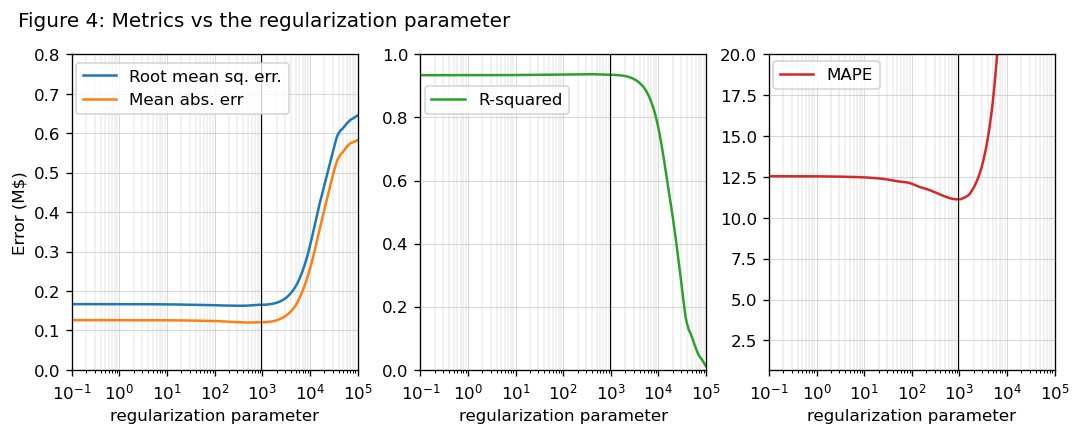

In [32]:
fig4, axs4 = plt.subplots(
    nrows=1, ncols=3, sharex=True, sharey=False, figsize=(9, 3.6), dpi=120,
    gridspec_kw={'left': 0.07, 'right': 0.98, 'top': 0.88, 'bottom': 0.15, 'wspace': 0.22})
fig4.suptitle("Figure 4: Metrics vs the regularization parameter",
              x=0.02, ha='left')

# RMSE and MAE
axs4[0].plot(alphas, metrics[1], color='C0',
             label='Root mean sq. err.')
axs4[0].plot(alphas, metrics[3], color='C1',
             label='Mean abs. err')
axs4[0].axvline(best_alpha, color='k', linewidth=0.6)

axs4[0].set_xscale('log')
axs4[0].set_xlim(1e-1, 1e5)
axs4[0].set_xticks(np.logspace(-1, 5, 7))
axs4[0].set_xticks(
    np.concatenate([np.linspace(10**i, 10**(i+1), 10) for i in range(-1, 5)]),
    minor=True)
axs4[0].set_xlabel('regularization parameter')
axs4[0].set_ylim(0, 8e5)
axs4[0].set_yticks(np.linspace(0, 8e5, 9),
                   [f'{i:.1f}' for i in np.linspace(0, 0.8, 9)])
axs4[0].set_ylabel('Error (M$)')
axs4[0].grid(visible=True, linewidth=0.3)
axs4[0].grid(visible=True, which='minor', linewidth=0.2)
axs4[0].legend(loc=(0.015, 0.81))

# R-squared
axs4[1].plot(alphas, metrics[2], color='C2', label='R-squared')
axs4[1].axvline(best_alpha, color='k', linewidth=0.6)

axs4[1].set_xlabel('regularization parameter')
axs4[1].set_ylim(0, 1)
axs4[1].grid(visible=True, linewidth=0.3)
axs4[1].grid(visible=True, which='minor', linewidth=0.2)
axs4[1].legend(loc=(0.015, 0.81))

# MAPE
axs4[2].plot(alphas, metrics[4], color='C3', label='MAPE')
axs4[2].axvline(best_alpha, color='k', linewidth=0.6)

axs4[2].set_xlabel('regularization parameter')
axs4[2].set_ylim(0.7e0, 2e1)
axs4[2].grid(visible=True, linewidth=0.3)
axs4[2].grid(visible=True, which='minor', linewidth=0.2)
axs4[2].legend(loc=(0.015, 0.89))


plt.show()

Figure 4 presents plots of our selected metrics as a function of the regularization parameter $\alpha$. We note that their values are stable up to about $\alpha \simeq 2000$, after which the performance of the model collapses. In particular, the mean absolute percentage error decreases by about 1% before exploding. This gives us a neat criterion to select $\alpha$: we choose the value at which the MAPE is minimal.

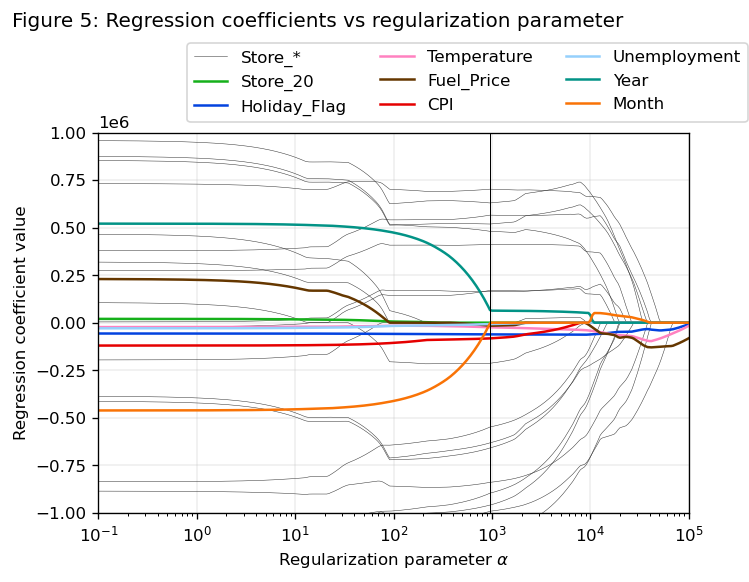

In [31]:
fig5, ax5 = plt.subplots(
    nrows=1, ncols=1, sharey=False, figsize=(6, 4.8), dpi=120,
    gridspec_kw={'left': 0.14, 'right': 0.96, 'top': 0.77, 'bottom': 0.11})
fig5.suptitle("Figure 5: Regression coefficients vs regularization parameter",
              x=0.02, ha='left')

for i in range(20):
    store_line, = ax5.plot(alphas, coefs[i], color='0.2', linewidth=0.3)

handles, labels = [store_line], ['Store_*'] # only one
for i in range(20, 28):
    line, = ax5.plot(alphas, coefs[i], color=COLORS[i-19])
    handles.append(line)
    labels.append(features[i])

ax5.axvline(best_alpha, color='k', linewidth=0.6)

ax5.set_xscale('log')
ax5.set_xlim(1e-1, 1e5)
ax5.set_xlabel(r'Regularization parameter $\alpha$')
ax5.set_ylim(-1e6, 1e6)
ax5.set_ylabel('Regression coefficient value')
ax5.grid(visible=True, linewidth=0.2)

fig5.legend(handles=handles, labels=labels,
            ncols=3, loc=(0.25, 0.79), alignment='center')

plt.show()

We show in figure 5 the evolution of the regression coefficients as a function of $\alpha$. As expected, they decrease as the regularization becomes stronger and actually start to collapse at $\alpha \sim 10^4$. We note that the `'Store_*'` coefficients (thin solid black lines) retain their value longer than other coefficients, which indicate that these are more important for the model. At our selected $\alpha$ (black vertical line), we see that the other coefficients (colored lines) have almost vanished.

### Evaluation of the model

We finally evaluate the model as we did for the unregularized model.

In [27]:
## train
lasso_model['regressor'].alpha = best_alpha
lasso_model.fit(X_tr, y_tr)


## evaluate of train set
y_pred_tr = lasso_model.predict(X_tr)
evaluation_df.iloc[2] = eval_metrics(y_tr, y_pred_tr)

## evaluate on test set
y_pred_test = lasso_model.predict(X_test)
evaluation_df.iloc[3] = eval_metrics(y_test, y_pred_test)


evaluation_df.loc['lasso']

,MSE ($^2),RMSE ($),R2,MAE ($),MAPE (%)
eval. set,,,,,
train,1.581518e+10,125758.434540,0.962405,94485.371015,8.812070
test,1.221439e+10,110518.737397,0.969288,86191.883841,9.505277


The metrics are again very similar for both train and test sets, and are of the same order as the values of the unregularized model.

In [28]:
# recover feature names
col_preproc = lasso_model['column_preprocessing']
features = ['intercept']
features += [feature_name.split('__')[1]
             for feature_name in col_preproc.get_feature_names_out()]

# get coefficients
intercept = lasso_model['regressor'].intercept_
coef_vals = np.concatenate([[intercept], lasso_model['regressor'].coef_])


for feature, coef in zip(features, coef_vals):
    print(f'{feature:<12} : {coef:>12.2f}')

intercept    :   1411860.34
Store_1      :    169800.94
Store_2      :    565882.34
Store_3      :   -991924.93
Store_4      :    629901.48
Store_5      :  -1120905.83
Store_6      :    164636.35
Store_7      :   -839877.71
Store_8      :   -548801.22
Store_9      :   -896879.72
Store_10     :    480694.66
Store_11     :         0.00
Store_12     :        -0.00
Store_13     :    519069.78
Store_14     :    702460.00
Store_15     :   -659000.73
Store_16     :   -959447.79
Store_17     :   -632175.41
Store_18     :   -213470.18
Store_19     :         0.00
Store_20     :    412208.95
Holiday_Flag :         0.00
Temperature  :    -62344.67
Fuel_Price   :    -24517.05
CPI          :    -16025.33
Unemployment :    -82617.18
Year         :     -7142.95
Month        :     66153.67
Week         :     -2736.01


The lasso model has 4 coefficients set to zero. We note that most non-`Store_<i>` values decreased, except `Temperature` and `Unemployment`. These retained a value similar to that of the unregularized model, which hints at their likely significance. Their effect is neverless small.

## <a id="conclusion"></a> Conclusion

We conclude by comparing the results for both unregularized and regularized linear regressions.

In [29]:
evaluation_df

MSE ($^2)       RMSE ($)        R2       MAE ($)  \
model         eval. set                                                        
unregularized train      1.426164e+10  119422.129170  0.966098  93226.632420   
              test       1.175835e+10  108435.938583  0.970435  86143.448027   
lasso         train      1.581518e+10  125758.434540  0.962405  94485.371015   
              test       1.221439e+10  110518.737397  0.969288  86191.883841   

                         MAPE (%)  
model         eval. set            
unregularized train      9.453533  
              test       9.674937  
lasso         train      8.812070  
              test       9.505277

The values are actually very similar for both models. The regularized model has 4 coefficients out of 28 set to zero, which makes it slightly simpler yet clearly not sparse. It must be stressed out however that this gain was not free: it came with an additional computational cost.